In [1]:
import os,io

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.patches as mpatches

sns.set(rc={'figure.figsize':(11, 4)})
sns.set(style="whitegrid")
%matplotlib inline

datadir = r"C:\Users\Timo\OneDrive - WMO\WIGOS\KPIs"

In [2]:
# mappings of ISO3 codes to WMO Region
df_iso_cpdb = pd.read_excel(r"C:\Users\Timo\OneDrive - WMO\GIS\WMO_Members.xlsx")[["id","wmo_region_id"]]
df_iso_cpdb.set_index("id",inplace=True)

df_iso = pd.read_excel(r"C:\Users\Timo\OneDrive - WMO\GIS\places-sovereign-mapping.xlsx")[["ISO_TER1","WMO_Region"]].drop_duplicates(subset=["ISO_TER1",])
df_iso.set_index("ISO_TER1",inplace=True)

gdf_ra = gpd.read_file(r"C:\Users\Timo\OneDrive - WMO\GIS\shapefiles\WMO_RAs.shp")
gdf_ra.crs = 'epsg:4326'


# calculating the final KPIs 

some functions and data used to match the observations 

In [3]:
def process_and_plot(df,map_by="latlon"):
    """ Need dataframe with columns center, indexnbr, nr_received, date, latitude and longitude
    """
    
    if map_by == "country_id" and not "country_id" in df.columns :
        raise Exception("country_id not in data")

    if map_by == "latlon":
        df=df.set_index("date").groupby(["center","indexnbr",pd.Grouper(freq="M")]).agg({"nr_received":"mean","latitude":"first","longitude":"first"}).reset_index()
    elif map_by == "country_id":
        df=df.set_index("date").groupby(["center","indexnbr",pd.Grouper(freq="M")]).agg({"nr_received":"mean","country_id":"first","latitude":"first","longitude":"first"}).reset_index()
    else:
        raise Exception("illegal arg")
    
    
    geometry = [Point(xy) for xy in zip(df.longitude , df.latitude)]
    crs =  'epsg:4326'

    gdf_stations = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

    if map_by == "latlon":
        gdf_join=gpd.sjoin(gdf_stations,gdf_ra[["WMO_RA","geometry"]],how="left",op="within")
    elif map_by == "country_id":
        gdf_join=gdf_stations.join(df_iso.rename(columns={"WMO_Region":"WMO_RA"}),on="country_id",how="left")
        
    gdf_join["WMO_RA"]=gdf_join.WMO_RA.fillna(0.0).astype(int)
   
    df_station_by_region_month_center = gdf_join.groupby(["center","date","WMO_RA"]).nr_received.sum().reset_index()

    df_nrstation_by_region_month_center=gdf_join.groupby(["date","center","WMO_RA"]).indexnbr.nunique().reset_index()
    df_nrstation_by_region_month_center.rename(columns={"indexnbr":"nr_stations"},inplace=True)

    data=df_station_by_region_month_center.groupby(["center","WMO_RA"]).nr_received.mean().reset_index()
    g1 = sns.catplot(x="WMO_RA",hue="center",y="nr_received",data=data , kind="bar" , palette="muted" )
    g1.despine(left=True)
    g1.set_ylabels("mean daily observations")
    g1.set_xlabels("WMO Region")

    
    data2=df_nrstation_by_region_month_center.groupby(["center","WMO_RA"]).nr_stations.mean().reset_index()
    g2 = sns.catplot(x="WMO_RA",hue="center",y="nr_stations",data=data2 , kind="bar" , palette="muted" )
    g2.despine(left=True)
    g2.set_ylabels("mean number of stations")
    g2.set_xlabels("WMO Region")

    
    data3=data.set_index(["center","WMO_RA"]).join(data2.set_index(["center","WMO_RA"]))
    data3["ratio"] = data3.nr_received / data3.nr_stations
    data3.reset_index(inplace=True)

    g3 = sns.catplot(x="WMO_RA",hue="center",y="ratio",data=data3 , kind="bar" , palette="muted" )
    g3.despine(left=True)
    g3.set_ylabels("mean number of daily observations per station")
    g3.set_xlabels("WMO Region")

    by_region = data.groupby("WMO_RA").nr_received.max().round().astype(int)
    total = data.groupby("WMO_RA").nr_received.max().round().astype(int).sum()

    #print("mean daily obs by region",by_region)
    #print("total daily obs",total)
    
    return [g1,g2,g3],by_region,total

## working with dataset from old system
Data is grouped by day,center and indexnbr.
We also have the latitude and longitude 

In [4]:
def load_old(filename):
    df_stations = pd.read_csv(os.path.join(datadir,filename),dtype={"max":"str","max.1":"str"})
    print("read",len(df_stations),"rows")
    df_stations.rename(columns={"max":"latitude","max.1":"longitude","dd":"day","mm":"month","yyyy":"year"},inplace=True)
    df_stations["latitude"]=df_stations["latitude"].str.split(",").str[0].astype(float)
    df_stations["longitude"]=df_stations["longitude"].str.split(",").str[0].astype(float)
    df_stations['date'] = pd.to_datetime(df_stations[['month','day','year']])
    df_stations=df_stations.drop(["year","month","day"],axis=1)
    idx = df_stations.nr_periods==4
    df_stations=df_stations[idx]
    print("removed",sum(~idx),"observations because of incomplete files")

    return df_stations


### SYNOP

read 13065281 rows
removed 108045 observations because of incomplete files


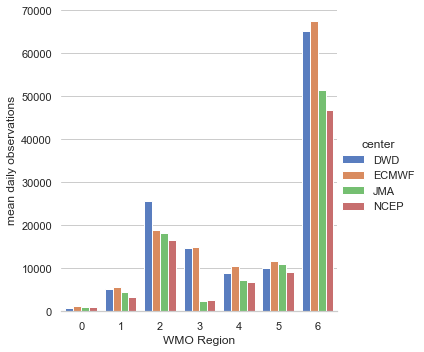

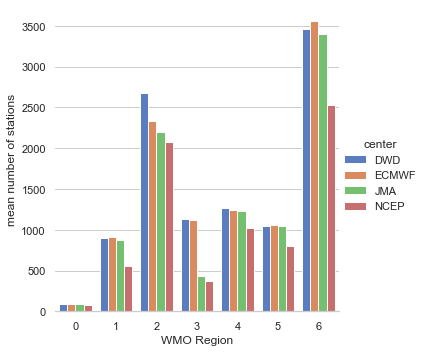

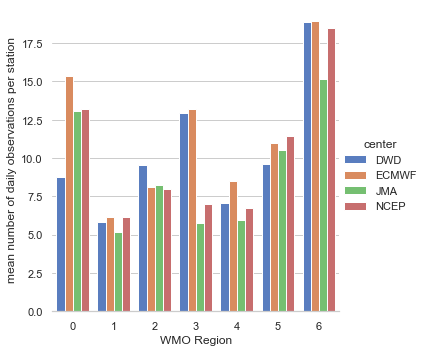

In [5]:
# load data
df_stations_synop_old = load_old("synop_by_station_center_month.csv.gz")
_,by_region_synop_old,total_synop_old=process_and_plot(df_stations_synop_old)

### TEMP

read 504651 rows
removed 636 observations because of incomplete files


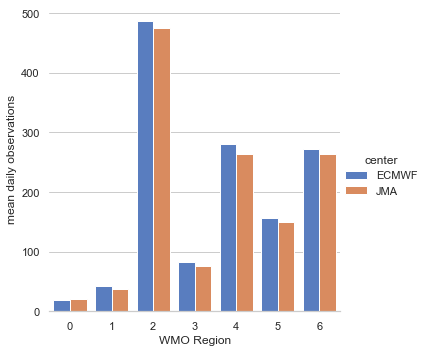

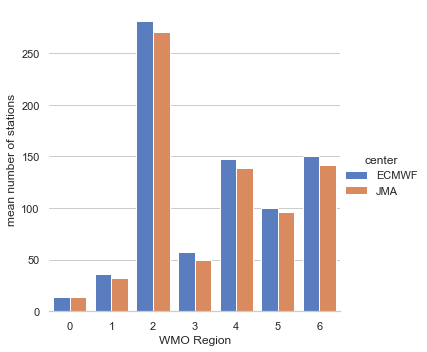

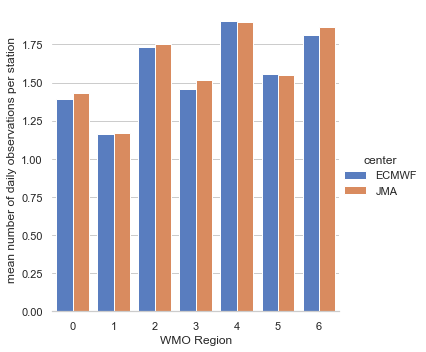

In [6]:
df_stations_synop_old = load_old("temp_by_station_center_month.csv.gz")
_,by_region_temp_old,_temp_old=process_and_plot(df_stations_synop_old)

## data from new WDQMS system.. 
grouped by station with lat/lon and country_id

In [7]:
def load_new(filename):
    df_stations = pd.read_csv(os.path.join(datadir,filename))
    print("read",len(df_stations),"rows")
    df_stations["date"]=pd.to_datetime(df_stations.date).dt.date.astype('datetime64')
    df_stations = df_stations.rename(columns={"wigosid":"indexnbr"})
    return df_stations


### SYNOP

C:\Users\Timo\Anaconda3\envs\data-analysis\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (0,4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


read 7862434 rows


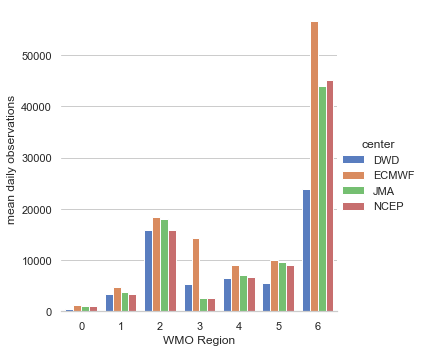

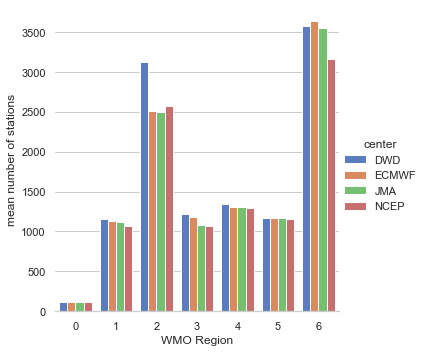

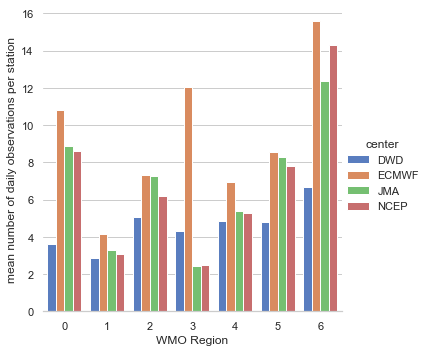

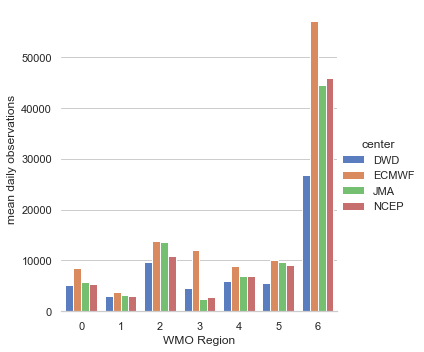

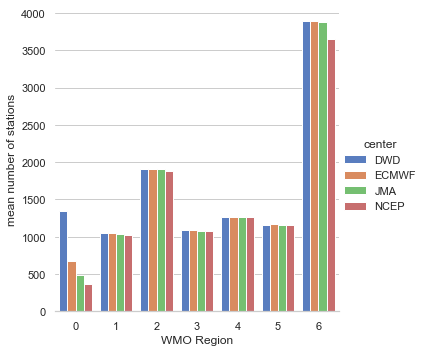

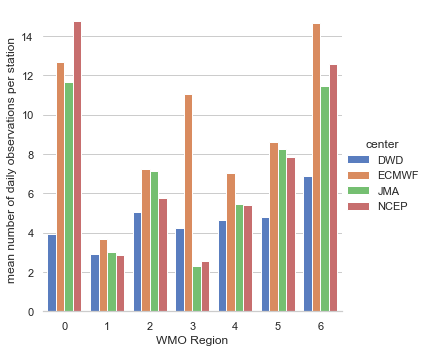

In [8]:
df_stations_synop = load_new("wdqms_synop_daily_2019_by_station_center.gz")

_,by_region_synop,total_synop=process_and_plot(df_stations_synop)
_,by_region_synop_country,total_synop_country=process_and_plot(df_stations_synop,map_by="country_id")

### TEMP

read 358327 rows


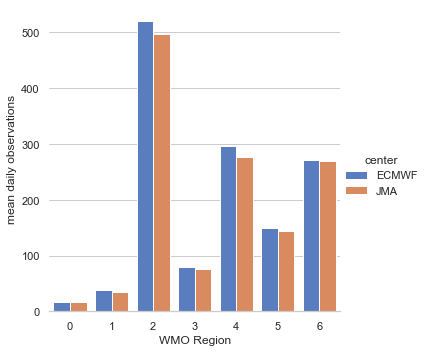

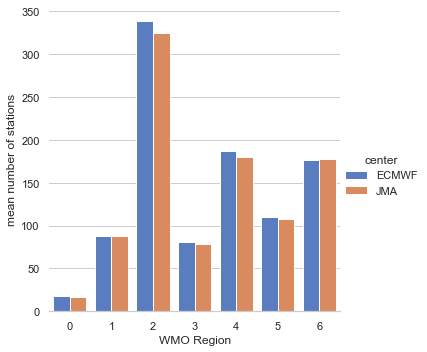

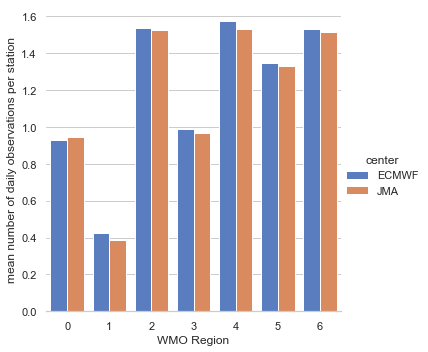

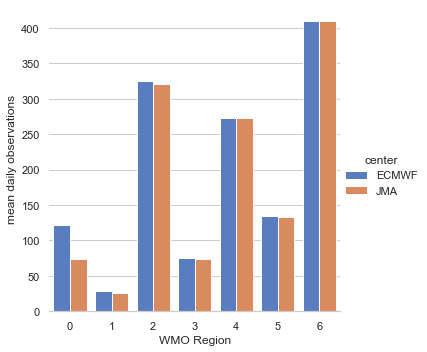

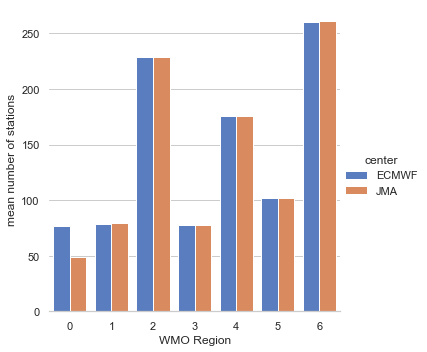

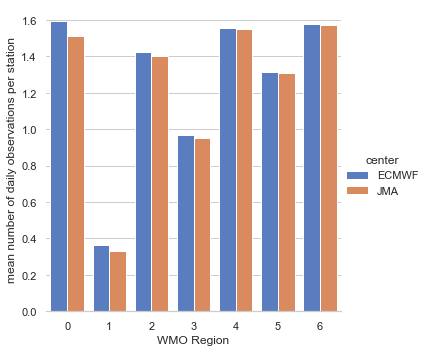

In [9]:
df_stations_temp_new = pd.read_csv(os.path.join(datadir,"wdqms_temp_daily_2019_by_station_center.gz"))
print("read",len(df_stations_temp_new),"rows")
df_stations_temp_new["date"]=pd.to_datetime(df_stations_temp_new.date).dt.date.astype('datetime64')
df_stations_temp_new = df_stations_temp_new.rename(columns={"wigosid":"indexnbr"})

figs4,by_region_temp,total_temp=process_and_plot(df_stations_temp_new)
figs5,by_region_temp_country,total_temp_country=process_and_plot(df_stations_temp_new,map_by="country_id")

## results

### synop

total new 114263


,nr_received,nr_received_new,nr_received_new_country
WMO_RA,,,
0,1345,1244,8553
1,5603,4657,3848
2,25555,18403,13833
3,14872,14240,12030
4,10550,9032,8904
5,11647,9986,10031
6,67449,56701,57065


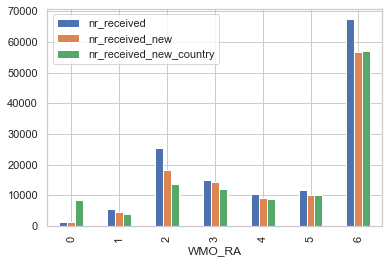

In [12]:
# combine old and new data
r=pd.DataFrame(data=by_region_synop_old).join(pd.DataFrame(data=by_region_synop),rsuffix="_new").join(pd.DataFrame(data=by_region_synop_country),rsuffix="_new_country")
r.plot.bar()

print("total new",total_synop)
r

### TEMP

total new 1371


,nr_received,nr_received_new,nr_received_new_country
WMO_RA,,,
0,20,16,122
1,42,38,29
2,486,521,326
3,83,80,76
4,280,296,273
5,156,149,134
6,273,271,410


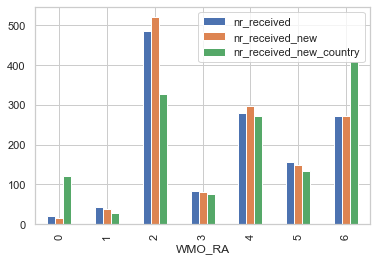

In [13]:
# combine old and new data
r=pd.DataFrame(data=by_region_temp_old).join(pd.DataFrame(data=by_region_temp),rsuffix="_new").join(pd.DataFrame(data=by_region_temp_country),rsuffix="_new_country")
r.plot.bar()

print("total new",total_temp)
r